# Metrics

This notebook should provide an overview over different metrics and how they are applied to machine learning systems.

## Prepare

The first step is to load a dataset and train a range of models (one for classification, one for regression)

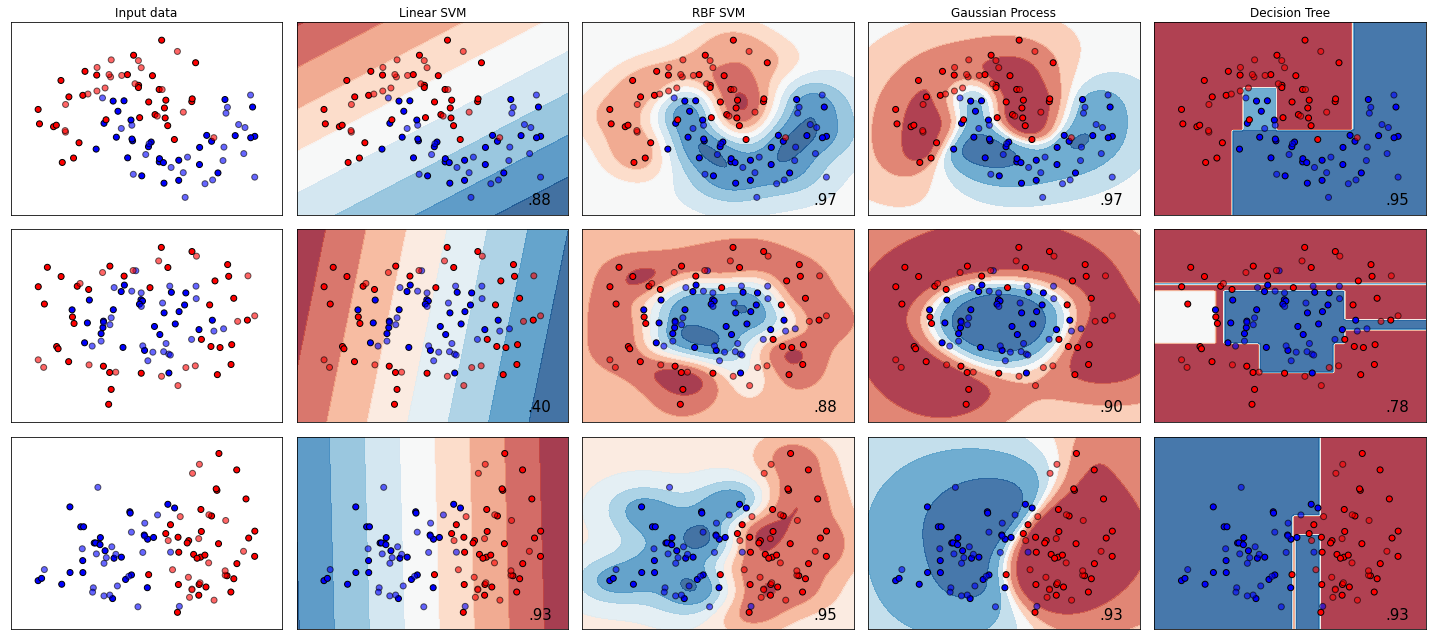

In [5]:
# general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
# data prepare
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification, make_moons, make_circles
# models
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay

names = [
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
]

classifiers = [
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
]

X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    linearly_separable,
]
scaled_datasets = []

figure = plt.figure(figsize=(20, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )
    scaled_datasets.append((X_train, X_test, y_train, y_test))

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        DecisionBoundaryDisplay.from_estimator(
            clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
        )

        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()

## Compute Metrics

Now we can compute different metrics given the input data and the classifiers

### Precision, Recall & F1-Measure

Computes the regarding values and presents them as a table:

In [13]:

res = []

for ds_cnt, ds in enumerate(scaled_datasets):
    # retrieve dataset
    X_train, X_test, y_train, y_test = ds

    # iterate classifiers
    for name, clf in zip(names, classifiers):
        # execute model
        # note: refit the model (since we use multiple datasets)
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)

        # retrieve base vals
        tn = np.sum((pred == 0) & (y_test == 0))
        tp = np.sum((pred == 1) & (y_test == 1))
        fp = np.sum((pred == 1) & (y_test == 0))
        fn = np.sum((pred == 0) & (y_test == 1))

        # compute metrics
        prec = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1_score = 2 * (prec * recall) / (prec + recall)

        # generate outputs
        out = {"dataset": ds_cnt, "classifier": name, "precision": prec, "recall": recall, "f1": f1_score}
        res.append(out)

# convert to dataframe
df = pd.DataFrame(res, columns=["dataset", "classifier", "precision", "recall", "f1"])
df = df.sort_values(["classifier", "dataset"]).set_index(["classifier", "dataset"])
df

/var/folders/8l/1_sx14l92sbg01mm4_s53_s40000gn/T/ipykernel_30419/2855705055.py:20: RuntimeWarning: invalid value encountered in long_scalars
  prec = tp / (tp + fp)


precision    recall        f1
classifier       dataset                               
Decision Tree    0         0.913043  1.000000  0.954545
                 1         0.863636  0.791667  0.826087
                 2         0.913043  0.954545  0.933333
Gaussian Process 0         0.954545  1.000000  0.976744
                 1         1.000000  0.833333  0.909091
                 2         0.952381  0.909091  0.930233
Linear SVM       0         0.900000  0.857143  0.878049
                 1              NaN  0.000000       NaN
                 2         1.000000  0.863636  0.926829
RBF SVM          0         0.954545  1.000000  0.976744
                 1         1.000000  0.791667  0.883721
                 2         1.000000  0.909091  0.952381

### Area Under the Curve (AUC)

Next we compute the Area under the curve for different cutoff values of the classifiers.

In [21]:
from sklearn.metrics import roc_curve, auc
res = []

for ds_cnt, ds in enumerate(scaled_datasets):
    # retrieve dataset
    X_train, X_test, y_train, y_test = ds

    # iterate classifiers
    for name, clf in zip(names, classifiers):
        # execute model
        # note: refit the model (since we use multiple datasets)
        clf.fit(X_train, y_train)
        if hasattr(clf, "predict_proba"):
            pred = clf.predict_proba(X_test)[:, 1]
        else:
            pred = clf.decision_function(X_test)
        print(pred)

        fpr, tpr, threholds = roc_curve(y_test, pred)
        print(threholds)
        roc_auc = auc(fpr, tpr)

        # generate outputs
        out = {"dataset": ds_cnt, "classifier": name, "fpr": fpr, "tpr": tpr, "auc": auc}
        print(out)
        res.append(out)

# convert to dataframe

[-0.86526438 -0.84668536 -0.64155726 -0.78534745  0.12840849  0.99427805
 -0.3542228  -1.16123427 -0.68202891 -0.85959462 -0.80469132  0.32366148
  0.81099283  0.45283988  1.11901353  0.82851164 -0.82434604  0.38938564
  1.31871112  1.36222574 -0.07043918  0.93381806 -0.01067511 -0.46954621
  1.59438682 -1.15910124  0.72271887  0.64242881  0.46335173 -0.49478038
  1.17514987 -0.8228186  -0.10353968  0.72058406  1.31559187  0.38765441
 -0.92116347  0.80425162 -0.96787413 -0.94681555]
[ 2.59438682  1.59438682  0.80425162  0.72271887  0.32366148 -0.01067511
 -0.10353968 -0.64155726 -0.68202891 -1.16123427]
{'dataset': 0, 'classifier': 'Linear SVM', 'fpr': array([0.        , 0.        , 0.        , 0.05263158, 0.05263158,
       0.15789474, 0.15789474, 0.36842105, 0.36842105, 1.        ]), 'tpr': array([0.        , 0.04761905, 0.52380952, 0.52380952, 0.85714286,
       0.85714286, 0.95238095, 0.95238095, 1.        , 1.        ]), 'auc': <function auc at 0x1497ae790>}
[-1.01763453 -0.633552